# HSCT survival: Cox proportional hazards model

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from sklearn.model_selection import train_test_split

import configuration as config
import functions.helper as helper_funcs

pd.set_option('display.max_rows', 500)

notebook_num='02.1'
feature_pval_cutoff=0.05
dataset='Continuous target encoded'

# Feature type definitions file
feature_types_dict_file=f'{config.PROCESSED_DATA}/01.1-feature_type_dict.pkl'

# Dataset definition file
datasets_file=f'{config.PROCESSED_DATA}/01.2-dataset_definitions.pkl'

# Significant features file
significant_features_file=f'{config.PROCESSED_DATA}/{notebook_num}-coxPH_significant_features.pkl'

# Model file
coxph_model_file=f'{config.MODELS_PATH}/{notebook_num}-coxPH_model.pkl'

# Output file
survival_file=f'{config.PROCESSED_DATA}/{notebook_num}-coxPH_survival.pkl'


## 1. Load data

In [2]:
# Read the dataset metadata
with open(datasets_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

print('Datasets:\n')
for description, filepath in datasets.items():
    print(f' {description}')

# Load feature definitions
with open(feature_types_dict_file, 'rb') as input_file:
    feature_types=pickle.load(input_file)

print('\nFeature types:\n')
for feature_type, features in feature_types.items():
    print(f' {feature_type}: {features}\n')

# Load one of the datasets
with open(datasets[dataset], 'rb') as input_file:
    data_dict=pickle.load(input_file)

print('Data dictionary contains:\n')
for key, value in data_dict.items():
    print(f' {key}: {type(value)}')

# Combine features and labels
training_df=data_dict['Training features']
training_df[['efs', 'efs_time']]=data_dict['Training labels']

testing_df=data_dict['Testing features']
testing_df[['efs', 'efs_time']]=data_dict['Testing labels']

Datasets:

 Nominal one-hot/ordinal encoded, NANs encoded
 Nominal one-hot/ordinal encoded, NANs imputed
 All ordinal encoded, NAN encoded
 All ordinal encoded, NAN imputed
 Binary target encoded
 Binary target encoded, power transformed
 Continuous target encoded
 Continuous target encoded, power transformed

Feature types:

 Interval: ['donor_age', 'age_at_hct']

 Ordinal: ['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10', 'dri_score', 'cyto_score', 'cmv_status', 'cyto_score_detail']

 Nominal: ['psych_disturb', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'tce_imm_match', 'rituximab', 'pr

In [3]:
training_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20160 entries, 0 to 20159
Data columns (total 59 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   psych_disturb           20160 non-null  float64
 1   diabetes                20160 non-null  float64
 2   tbi_status              20160 non-null  float64
 3   arrhythmia              20160 non-null  float64
 4   graft_type              20160 non-null  float64
 5   vent_hist               20160 non-null  float64
 6   renal_issue             20160 non-null  float64
 7   pulm_severe             20160 non-null  float64
 8   prim_disease_hct        20160 non-null  float64
 9   tce_imm_match           20160 non-null  float64
 10  rituximab               20160 non-null  float64
 11  prod_type               20160 non-null  float64
 12  conditioning_intensity  20160 non-null  float64
 13  ethnicity               20160 non-null  float64
 14  obesity                 20160 non-null

## 2. Cox proportional hazards model

### 2.1. Naive model

In [4]:
cph_model=CoxPHFitter()
cph_model.fit(training_df, duration_col='efs_time', event_col='efs')

<lifelines.CoxPHFitter: fitted with 20160 total observations, 9292 right-censored observations>

### 2.2. Feature p-values

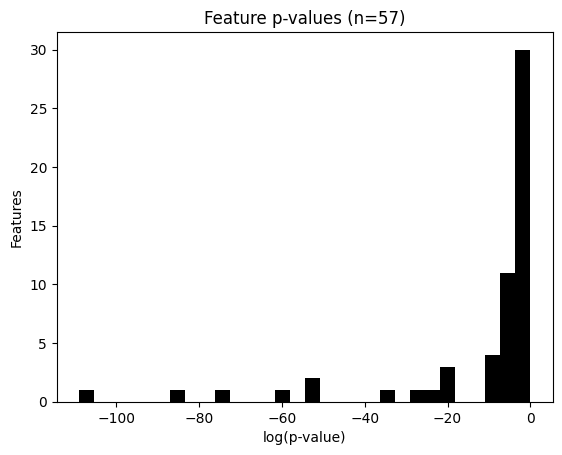

Significant features at alpha = 0.05: 30
Significant features at alpha = 0.001: 16


In [5]:
feature_pvals=cph_model.summary['p']

plt.title(f'Feature p-values (n={len(feature_pvals)})')
plt.hist(np.log(feature_pvals), color='black', bins=30)
plt.xlabel('log(p-value)')
plt.ylabel('Features')
plt.show()

significant_features=feature_pvals[feature_pvals < 0.05]
print(f'Significant features at alpha = 0.05: {len(significant_features)}')

significant_features=feature_pvals[feature_pvals < 0.001]
print(f'Significant features at alpha = 0.001: {len(significant_features)}')

### 2.3. Feature selection

In [6]:
training_significant_features_df=training_df[feature_pvals[feature_pvals < feature_pval_cutoff].index].copy()
testing_significant_features_df=testing_df[feature_pvals[feature_pvals < feature_pval_cutoff].index].copy()

# Save the significant features list
significant_features=list(training_significant_features_df.columns)

with open(significant_features_file, 'wb') as output_file:
    pickle.dump(significant_features, output_file)

training_significant_features_df['efs']=training_df['efs']
training_significant_features_df['efs_time']=training_df['efs_time']
testing_significant_features_df['efs']=testing_df['efs']
testing_significant_features_df['efs_time']=testing_df['efs_time']

### 2.4. Model re-training

In [7]:
cph_model=CoxPHFitter()
cph_model.fit(training_significant_features_df, duration_col='efs_time', event_col='efs')
cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 20160 total observations, 9292 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 20160
number of events observed = 10868
   partial log-likelihood = -102311.35
         time fit was run = 2025-03-05 15:02:48 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
psych_disturb          -0.01      0.99      0.01           -0.02            0.00                0.98                1.00
diabetes               -0.01      0.99      0.00           -0.02            0.00                0.98                1.00
tbi_status             -0.06      0.95      0.01           -0.07           -0.04                0.93                0.96
graft_type             -0.02      0.98      0.00           -0.03           -0.01                0.98                0.99
vent_hist              -0.16      0.86      0.04           -0.24           -0.07                0.79                0.93
pulm_severe            -0.03      0.97      0.00           -0.04           -0.02                0.97                0.98
prim_disease_hct       -0.03      0.97      0.00           -0.03           -0.02                0.97                0.98
rituximab               0.03      1.04      0.01            0.02            0.05                1.02                1.06
conditioning_intensity -0.04      0.96      0.00           -0.05           -0.04                0.95                0.96
mrd_hct                 0.03      1.03      0.01            0.02            0.05                1.02                1.05
in_vivo_tcd            -0.01      0.99      0.00           -0.02           -0.01                0.98                0.99
tce_match              -0.03      0.97      0.01           -0.05           -0.01                0.96                0.99
gvhd_proph             -0.01      0.99      0.00           -0.02           -0.00                0.98                1.00
sex_match              -0.07      0.93      0.01           -0.08           -0.06                0.93                0.94
race_group             -0.04      0.96      0.01           -0.05           -0.03                0.95                0.97
melphalan_dose          0.04      1.04      0.01            0.02            0.05                1.02                1.06
cardiac                -0.02      0.98      0.00           -0.03           -0.01                0.97                0.99
hla_match_c_high        0.04      1.05      0.01            0.02            0.07                1.02                1.07
hla_match_dqb1_high     0.15      1.16      0.04            0.08            0.22                1.08                1.24
hla_nmdp_6             -0.03      0.97      0.01           -0.06           -0.01                0.94                0.99
hla_match_dqb1_low      0.07      1.07      0.03            0.02            0.12                1.02                1.13
year_hct                0.01      1.01      0.00            0.01            0.01                1.01                1.01
hla_match_a_high       -0.02      0.98      0.01           -0.05            0.01                0.95                1.01
hla_match_b_low         0.04      1.04      0.02            0.01            0.08                1.01                1.08
hla_match_a_low        -0.04      0.96      0.01           -0.07           -0.02                0.94                0.98
comorbidity_score      -0.04      0.96      0.00           -0.04           -0.03                0.96                0.97
karnofsky_score        -0.03      0.97      0.00           -0.04           -0.03                0.96                0.97
hla_match_drb1_high    -0.05      0.95      0.02           -0.08           -0.02                0.92                0.98
d

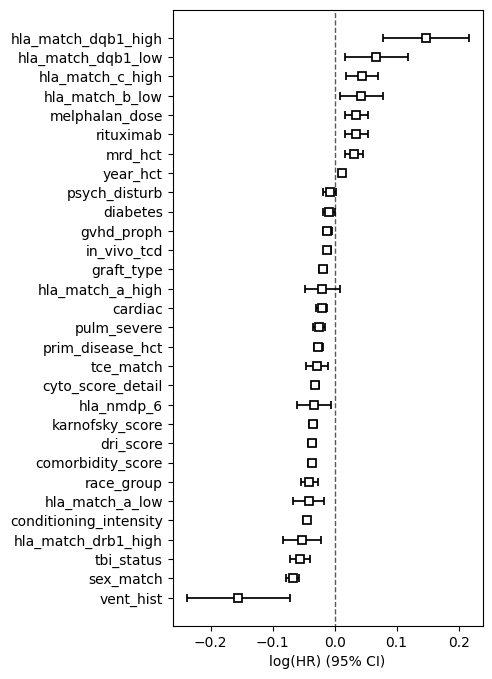

In [8]:
fig=plt.figure(figsize=[4,8])
cph_model.plot(figure=fig)
plt.show()

In [9]:
cph_model.check_assumptions(training_significant_features_df, p_value_threshold=feature_pval_cutoff)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 20160 total observations, 9292 right-censored observations>
         test_name = proportional_hazard_test

---
                             test_statistic      p  -log2(p)
cardiac                km              2.60   0.11      3.23
                       rank            2.58   0.11      3.21
comorbidity_score      km             82.53 <0.005     63.06
                       rank           82.50 <0.005     63.04
conditioning_intensity km             41.72 <0.005     33.14
                       rank           41.73 <0.005     33.16
cyto_score_detail      km             15.37 <0.005     13.46
                       rank           15.36 <0.005     13.45
diabetes               km              5.57   0.02      5.78
                       rank            5.58   0.02      5.79
dri_score              km             20.72 <0.005     17.52
                       rank           20.73 <0.005     17.53
graft_type             km             52.70 <0.005     41.23
                       rank           52.68 <0.005     41.21
gvhd_proph             km             35.16 <0.005     28.29
                       rank           35.17 <0.005     28.31
hla_match_a_high       km              6.38   0.01      6.44
                       rank            6.38   0.01      6.44
hla_match_a_low        km             12.94 <0.005     11.60
                       rank           12.94 <0.005     11.60
hla_match_b_low        km              5.52   0.02      5.73
                       rank            5.52   0.02      5.73
hla_match_c_high       km              0.23   0.63      0.66
                       rank            0.23   0.63      0.67
hla_match_dqb1_high    km             24.06 <0.005     20.03
                       rank           24.05 <0.005     20.02
hla_match_dqb1_low     km              0.21   0.65      0.62
                       rank            0.20   0.65      0.62
hla_match_drb1_high    km              8.37 <0.005      8.04
                       rank            8.38 <0.005      8.04
hla_nmdp_6             km              1.95   0.16      2.62
                       rank            1.94   0.16      2.61
in_vivo_tcd            km            162.46 <0.005    121.20
                       rank          162.45 <0.005    121.19
karnofsky_score        km             89.84 <0.005     68.39
                       rank           89.87 <0.005     68.42
melphalan_dose         km              0.45   0.50      0.99
                       rank            0.45   0.50      0.99
mrd_hct                km            313.14 <0.005    230.36
                       rank          313.25 <0.005    230.44
prim_disease_hct       km              2.12   0.15      2.78
                       rank            2.12   0.15      2.79
psych_disturb          km              0.26   0.61      0.71
                       rank            0.26   0.61      0.71
pulm_severe            km              7.36   0.01      7.23
                       rank            7.38   0.01      7.25
race_group             km              1.50   0.22      2.18
                       rank            1.52   0.22      2.20
rituximab              km             19.86 <0.005     16.88
                       rank           19.90 <0.005     16.90
sex_match              km              0.87   0.35      1.51
                       rank            0.87   0.35      1.52
tbi_status             km              1.17   0.28      1.84
                       rank            1.18   0.28      1.85
tce_match              km             12.85 <0.005     11.53
                       rank           12.86 <0.005     11.54
vent_hist              km              0.02   0.88      0.18
                       rank            0.02   0.88      0.18
year_hct               km            142.58 <0.005    106.76
                       rank          142.27 <0.005    106.54



1. Variable 'diabetes' failed the non-proportional test: p-value is 0.0181.

   Advice: with so few unique values (only 3), you can include `strata=['diabetes', ...]` in the
call in `.fit`. See documentation in link [E] below.

2. Variable 'graft_type' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['graft_type', ...]` in the
call in `.fit`. See documentation in link [E] below.

3. Variable 'pulm_severe' failed the non-proportional test: p-value is 0.0066.

   Advice: with so few unique values (only 3), you can include `strata=['pulm_severe', ...]` in the
call in `.fit`. See documentation in link [E] below.

4. Variable 'rituximab' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 3), you can include `strata=['rituximab', ...]` in the
call in `.fit`. See documentation in link [E] below.

5. Variable 'conditioning_intensity' failed the non-proportional test: p-v

[]

## 3. Survival forecasting

In [10]:
# Predict new survival function for training participants
training_survival_functions=cph_model.predict_survival_function(training_significant_features_df)
training_partial_hazards=cph_model.predict_partial_hazard(training_significant_features_df)
training_survival_df=training_df[['efs', 'efs_time']].copy()
training_survival_df['Survival']=training_survival_functions.iloc[-1]
training_survival_df['Partial hazard']=training_partial_hazards

# Predict new survival function for testing participants
testing_survival_functions=cph_model.predict_survival_function(testing_significant_features_df)
testing_partial_hazards=cph_model.predict_partial_hazard(testing_significant_features_df)
testing_survival_df=testing_df[['efs', 'efs_time']].copy()
testing_survival_df['Survival']=testing_survival_functions.iloc[-1]
testing_survival_df['Partial hazard']=testing_partial_hazards

training_survival_df.head()

,efs,efs_time,Survival,Partial hazard
0,1.0,2.142,0.291155,1.629823
1,0.0,105.944,0.457546,1.032759
2,0.0,34.787,0.631007,0.608179
3,1.0,6.964,0.196610,2.148440
4,1.0,5.541,0.349571,1.388300


### 3.1. Survival curves

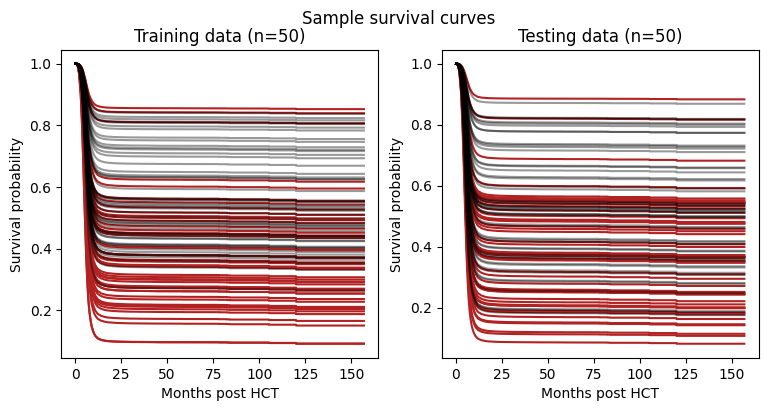

In [11]:
n_curves=50

# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

fig.suptitle('Sample survival curves')

efs_positive_ids=training_significant_features_df[training_significant_features_df['efs'] == 1].index
efs_negative_ids=training_significant_features_df[training_significant_features_df['efs'] == 0].index

efs_negative_survival_functions=training_survival_functions[efs_negative_ids]
efs_positive_survival_functions=training_survival_functions[efs_positive_ids]

axs[0].set_title(f'Training data (n={n_curves})')

for i in range(n_curves):
    axs[0].plot(efs_positive_survival_functions.index, efs_positive_survival_functions.iloc[:,i], color='firebrick', label='EFS 1')

for i in range(n_curves):
    axs[0].plot(efs_negative_survival_functions.index, efs_negative_survival_functions.iloc[:,i], color='black', alpha=0.4, label='EFS 0')

axs[0].set_xlabel('Months post HCT')
axs[0].set_ylabel('Survival probability')

efs_positive_ids=testing_significant_features_df[testing_significant_features_df['efs'] == 1].index
efs_negative_ids=testing_significant_features_df[testing_significant_features_df['efs'] == 0].index

efs_negative_survival_functions=testing_survival_functions[efs_negative_ids]
efs_positive_survival_functions=testing_survival_functions[efs_positive_ids]

axs[1].set_title(f'Testing data (n={n_curves})')

for i in range(n_curves):
    axs[1].plot(efs_positive_survival_functions.index, efs_positive_survival_functions.iloc[:,i], color='firebrick', label='EFS 1')

for i in range(n_curves):
    axs[1].plot(efs_negative_survival_functions.index, efs_negative_survival_functions.iloc[:,i], color='black', alpha=0.4, label='EFS 0')

axs[1].set_xlabel('Months post HCT')
axs[1].set_ylabel('Survival probability')

plt.show()

### 3.2. Survival probability at study end

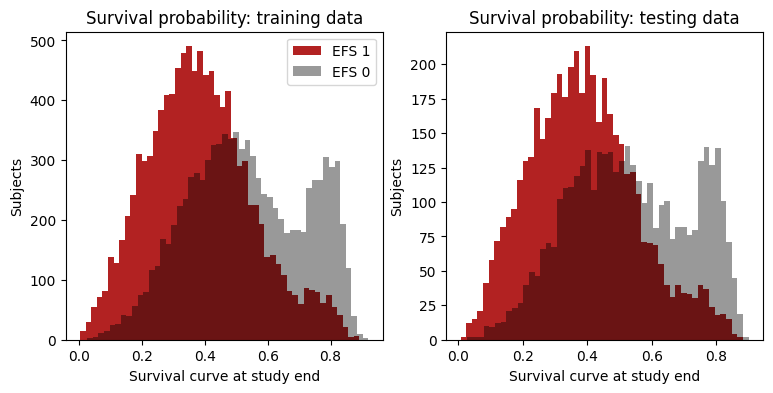

In [12]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

efs_positive_df=training_survival_df[training_survival_df['efs'] == 1]
efs_negative_df=training_survival_df[training_survival_df['efs'] == 0]

axs[0].set_title('Survival probability: training data')
axs[0].hist(efs_positive_df['Survival'], bins=50, color='firebrick', label='EFS 1')
axs[0].hist(efs_negative_df['Survival'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[0].set_xlabel('Survival curve at study end')
axs[0].set_ylabel('Subjects')
axs[0].legend(loc='best')

efs_positive_df=testing_survival_df[testing_survival_df['efs'] == 1]
efs_negative_df=testing_survival_df[testing_survival_df['efs'] == 0]

axs[1].set_title('Survival probability: testing data')
axs[1].hist(efs_positive_df['Survival'], bins=50, color='firebrick', label='EFS 1')
axs[1].hist(efs_negative_df['Survival'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[1].set_xlabel('Survival curve at study end')
axs[1].set_ylabel('Subjects')

plt.show()

### 3.3. Partial hazard

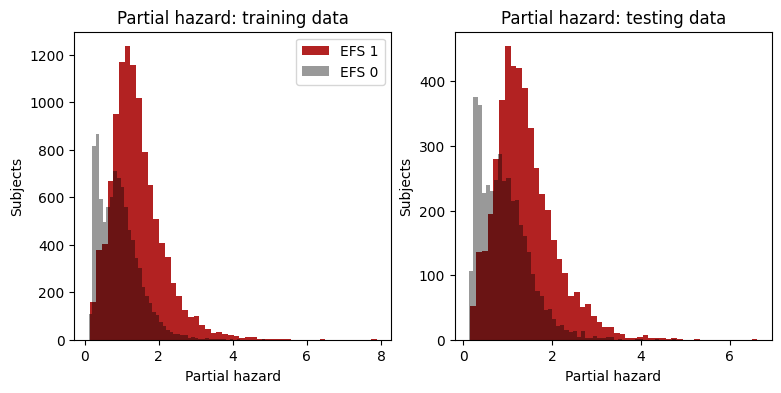

In [13]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

efs_positive_df=training_survival_df[training_survival_df['efs'] == 1]
efs_negative_df=training_survival_df[training_survival_df['efs'] == 0]

axs[0].set_title('Partial hazard: training data')
axs[0].hist(efs_positive_df['Partial hazard'], bins=50, color='firebrick', label='EFS 1')
axs[0].hist(efs_negative_df['Partial hazard'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[0].set_xlabel('Partial hazard')
axs[0].set_ylabel('Subjects')
axs[0].legend(loc='best')

efs_positive_df=testing_survival_df[testing_survival_df['efs'] == 1]
efs_negative_df=testing_survival_df[testing_survival_df['efs'] == 0]

axs[1].set_title('Partial hazard: testing data')
axs[1].hist(efs_positive_df['Partial hazard'], bins=50, color='firebrick', label='EFS 1')
axs[1].hist(efs_negative_df['Partial hazard'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[1].set_xlabel('Partial hazard')
axs[1].set_ylabel('Subjects')

plt.show()

### 3.4. C-index scoring

In [14]:
scoring_results=helper_funcs.score_predictions(
    'CoxPH survival',
    testing_survival_df['Survival'].values,
    testing_survival_df['efs_time'].values,
    testing_survival_df['efs'].values,
    data_dict['Testing race group'],
    data_dict['Testing IDs']
)

scoring_results=helper_funcs.score_predictions(
    'CoxPH partial hazard',
    -testing_survival_df['Partial hazard'].values,
    testing_survival_df['efs_time'].values,
    testing_survival_df['efs'].values,
    data_dict['Testing race group'],
    data_dict['Testing IDs'],
    results=scoring_results
)

scoring_results_df=pd.DataFrame(scoring_results)
scoring_results_df.head()

,Model,RMSE,C-index,Stratified C-index
0,CoxPH survival,33.333034,0.647351,0.63166
1,CoxPH partial hazard,34.393694,0.647351,0.63166


## 4. Save survival features

In [15]:
coxph_features={
    'Training survival': list(training_survival_df['Survival'].values),
    'Training partial hazard': list(training_survival_df['Partial hazard'].values),
    'Testing survival': list(testing_survival_df['Survival'].values),
    'Testing partial hazard': list(testing_survival_df['Partial hazard'].values)
}

with open(survival_file, 'wb') as output_file:
    pickle.dump(coxph_features, output_file)

## 5. Save model

In [16]:
with open(coxph_model_file, 'wb') as output_file:
    pickle.dump(cph_model, output_file)